In [77]:
import importlib
import time
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
from scipy import ndimage
from scipy import interpolate

In [2]:
from multi_loc import covariance, assimilate, utilities

In [3]:
%matplotlib inline

In [4]:
def imshow(X, title=None, vmin=None, vmax=None, cmap=None):
    plt.figure()
    im = plt.imshow(X, vmin=vmin, vmax=vmax, cmap=cmap)
    plt.colorbar(im)
    plt.title(title)

In [503]:
dimension = 2**9
print(dimension)
rho0_l = 0.09
rho0_s = 0.003
# rho0 = 0.2
# dx = 0.25
dx = 1/dimension

# obs_size = int(dimension/2)
# H = assimilate.random_H(dimension, obs_size)

H = np.eye(dimension)[::2]
obs_size = H.shape[0]

rho = np.arange(dimension, dtype=float)
rho = np.minimum(rho, (dimension - rho) % dimension)
rho = rho*dx

512


In [504]:
eig_val_l, eig_vec_l, P_l, sort_index = covariance.generate_circulant(
    dimension, dx, rho0_l, covariance.fft_sqd_exp_1d,
    return_Corr=True, return_sort_ind=True)
print('long variance: ', eig_val_l.mean())
eig_val_l = eig_val_l / eig_val_l.mean()
sort_index = np.argsort(sort_index)
eig_val_l = eig_val_l[sort_index]
eig_vec_l = eig_vec_l[:, sort_index]
P_l = eig_vec_l @ np.diag(eig_val_l) @ eig_vec_l.conj().T
P_l = P_l.real

eig_val_s, eig_vec_s, P_s, sort_index = covariance.generate_circulant(
    dimension, dx, rho0_s, covariance.fft_sqd_exp_1d,
    return_Corr=True, return_sort_ind=True)
print('short variance: ', eig_val_s.mean())
eig_val_s = eig_val_s / eig_val_s.mean()
sort_index = np.argsort(sort_index)
eig_val_s = eig_val_s[sort_index]
eig_vec_s = eig_vec_s[:, sort_index]
P_s = eig_vec_s @ np.diag(eig_val_s) @ eig_vec_s.conj().T
P_s = P_s.real
#P_s = P_s/P_s.max()

al = 0.5
eig_val = (1 - al) * eig_val_s + al * eig_val_l
eig_vec = eig_vec_l.copy()

eig_val = eig_val / eig_val.mean()

sort_index = np.argsort(eig_val)[::-1]
eig_val = eig_val[sort_index]
eig_vec = eig_vec[:, sort_index]

P = eig_vec @ np.diag(eig_val) @ eig_vec.conj().T
P = P.real

sort_index = np.argsort(eig_val_l)[::-1]
eig_val_l = eig_val_l[sort_index]
eig_vec_l = eig_vec_l[:, sort_index]

sort_index = np.argsort(eig_val_s)[::-1]
eig_val_s = eig_val_s[sort_index]
eig_vec_s = eig_vec_s[:, sort_index]

R_sig = 1
R = R_sig * np.eye(obs_size)

trans_mats_true = assimilate.transformation_matrices(
    H, eig_val_p=eig_val, eig_vec_p=eig_vec,
    R=R, return_Ts=True)


trans_mats_long = assimilate.transformation_matrices(
    H, eig_val_p=eig_val_l, eig_vec_p=eig_vec_l,
    R=R, return_Ts=True)


trans_mats_short = assimilate.transformation_matrices(
    H, eig_val_p=eig_val_s, eig_vec_p=eig_vec_s,
    R=R, return_Ts=True)


for key, val in trans_mats_true.items():
    exec(key + '=val')
for key, val in trans_mats_long.items():
    exec(key+'_l' + '=val')
for key, val in trans_mats_short.items():
    exec(key+'_s' + '=val')

long variance:  1.0
short variance:  0.999998602378286


Log10(condition):  6.5477037050343725


Text(0.5, 0.98, 'Eigenvalues P_s')

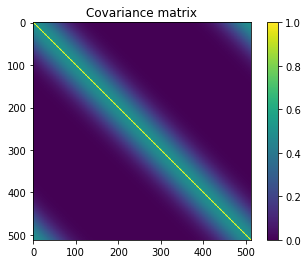

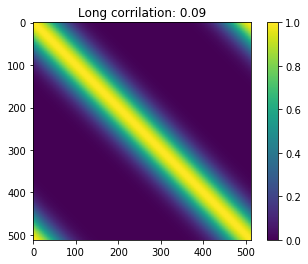

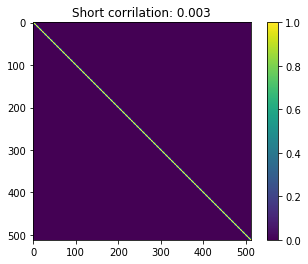

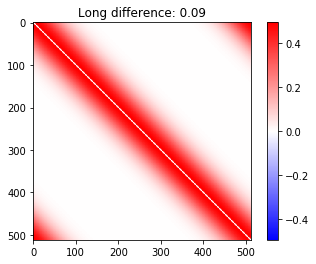

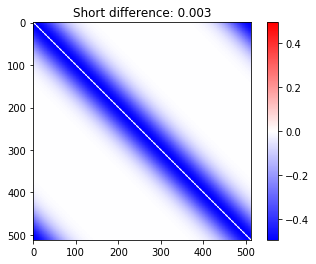

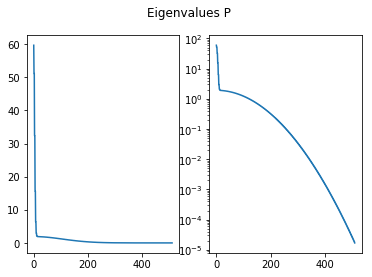

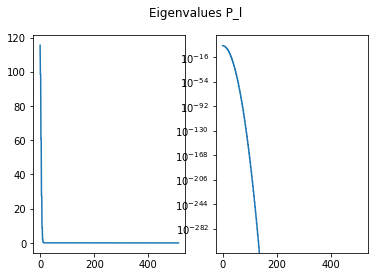

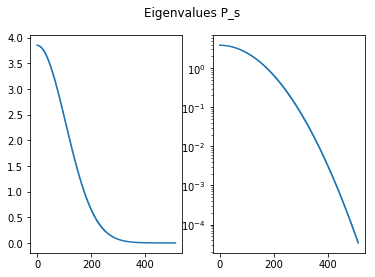

In [505]:
imshow(P, title='Covariance matrix', vmin=0, vmax=1)
imshow(P_l, title=f'Long corrilation: {rho0_l}', vmin=0, vmax=1)
imshow(P_s, title=f'Short corrilation: {rho0_s}', vmin=0, vmax=1)

error_l = P_l - P
error_s = P_s - P

vmax = np.max([np.abs(error_l).max(),
               np.abs(error_s).max()])

imshow(error_l, title=f'Long difference: {rho0_l}',
       vmin=-vmax, vmax=vmax, cmap='bwr')
imshow(error_s, title=f'Short difference: {rho0_s}',
       vmin=-vmax, vmax=vmax, cmap='bwr')
print('Log10(condition): ',
      np.log10(np.linalg.cond(P)))

fig, ax = plt.subplots(1, 2)
ax[0].plot(eig_val)
ax[1].semilogy(eig_val)
plt.suptitle('Eigenvalues P')

fig, ax = plt.subplots(1, 2)
ax[0].plot(eig_val_l)
ax[1].semilogy(eig_val_l)
plt.suptitle('Eigenvalues P_l')

fig, ax = plt.subplots(1, 2)
ax[0].plot(eig_val_s)
ax[1].semilogy(eig_val_s)
plt.suptitle('Eigenvalues P_s')

# R^{-1/2} H P^{1/2} = U S VT

In [506]:
trans_mats = assimilate.transformation_matrices(
    H, eig_val_p=eig_val, eig_vec_p=eig_vec,
    R=R, return_Ts=True)

for key, val in trans_mats.items():
    print(key)
    exec(key + '=val')

P_sqrt
P_inv_sqrt
R_sqrt
R_inv_sqrt
U
S
VT
H
Tx
Tx_inv
Ty
Ty_inv


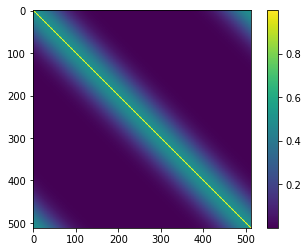

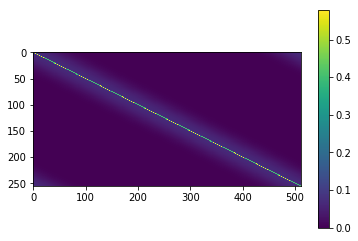

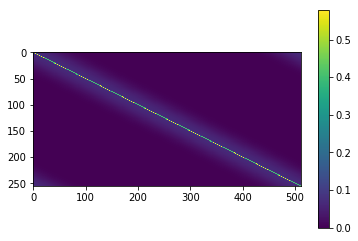

In [509]:
imshow(P_sqrt @ P_sqrt)
imshow(H @ P_sqrt)
imshow(U @ S @ VT)

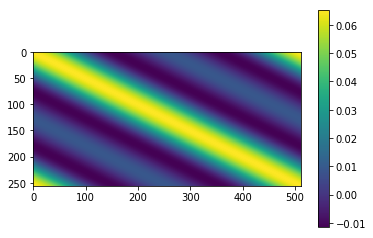

In [510]:
sig_num = 5
imshow(U[:, :sig_num] @ S[:sig_num, :sig_num] @ VT[:sig_num])

In [740]:
ens_size = 30
X = assimilate.generate_ensemble(ens_size=ens_size,
                                       mu=np.zeros(dimension),
                                       eig_val=eig_val,
                                       eig_vec=eig_vec
                                       )
P_sample = np.cov(X)

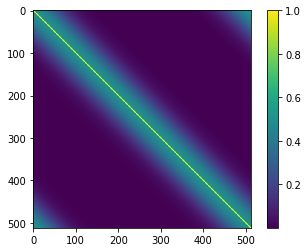

In [741]:
imshow(P)

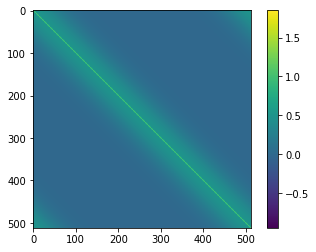

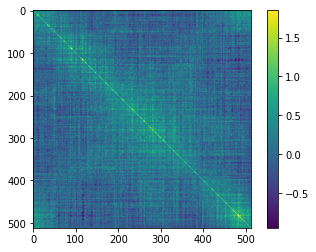

In [739]:
vmax = np.max([P_sample.max(), P.max()])
vmin = np.min([P_sample.min(), P.min()])

imshow(P, vmax=vmax, vmin=vmin)
imshow(P_sample, vmax=vmax, vmin=vmin)

In [743]:
def loc_with_trans(P_sample, P_sqrt, P_inv_sqrt, VT):
    P_til_loc = np.diag(np.diag(
        VT @ P_inv_sqrt @ P_sample @ P_inv_sqrt @ VT.T))
    P_sample_loc = P_sqrt @ VT.T @ P_til_loc @ VT @ P_sqrt
    return P_sample_loc

In [744]:
def test_trans_matrices(P, P_sample, P_sqrt, P_inv_sqrt, VT, title):
    P_sample_loc = loc_with_trans(P_sample=P_sample,
                                  P_sqrt=P_sqrt,
                                  P_inv_sqrt=P_inv_sqrt,
                                  VT=VT)
    vmax = np.max([P_sample.max(), P_sample_loc.max(), P.max()])
    vmin = np.min([P_sample.min(), P_sample_loc.min(), P.min()])

    imshow(P, vmax=vmax, vmin=vmin, title='truth')
    imshow(P_sample, vmax=vmax, vmin=vmin, title='sample')
    imshow(P_sample_loc, vmax=vmax, vmin=vmin, title=title)
    
    error_sample = P - P_sample
    error_loc = P - P_sample_loc
    L2_sample = np.round(np.linalg.norm(error_sample, ord=2), decimals=1)
    L2_loc = np.round(np.linalg.norm(error_loc, ord=2), decimals=1)
    vmax = np.max([np.abs(error_sample).max(),
                   np.abs(error_loc).max()])
    imshow(error_sample, vmax=vmax, vmin=-vmax,
           title='sample error' + f'; L2: {L2_sample}', cmap='bwr')
    imshow(error_loc, vmax=vmax, vmin=-vmax,
           title=title +' error' + f'; L2: {L2_loc}', cmap='bwr')
    return P_sample_loc

In [745]:
P_sample_loc = loc_with_trans(P_sample=P_sample,
                              P_sqrt=P_sqrt,
                              P_inv_sqrt=P_inv_sqrt,
                              VT=VT)

array([[1.04845553, 0.95191004, 0.75974044, ..., 0.61591187, 0.75602042,
        0.94986087],
       [0.95191004, 1.04663856, 0.94913569, ..., 0.56091369, 0.62128395,
        0.76183171],
       [0.75974044, 0.94913569, 1.04445637, ..., 0.54685211, 0.56701686,
        0.62333312],
       ...,
       [0.61591187, 0.56091369, 0.54685211, ..., 1.04053982, 0.94334999,
        0.75375131],
       [0.75602042, 0.62128395, 0.56701686, ..., 0.94334999, 1.03984524,
        0.9444888 ],
       [0.94986087, 0.76183171, 0.62333312, ..., 0.75375131, 0.9444888 ,
        1.04212766]])

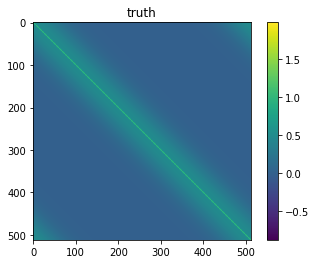

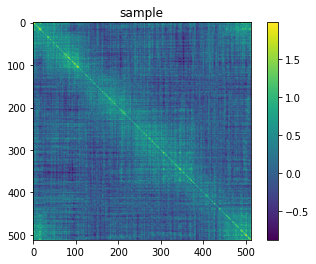

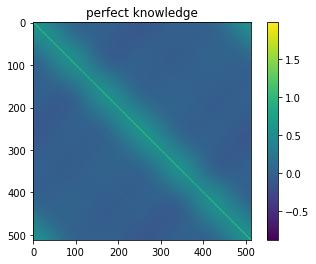

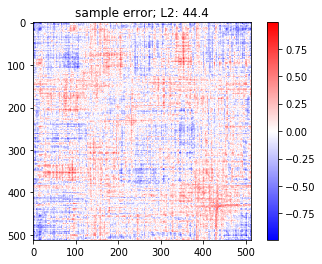

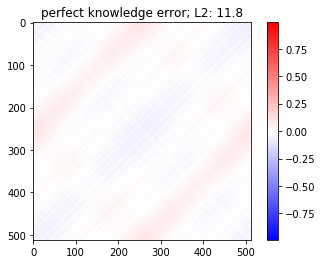

In [746]:
test_trans_matrices(P=P,
                    P_sample=P_sample,
                    P_sqrt=P_sqrt,
                    P_inv_sqrt=P_inv_sqrt,
                    VT=VT,
                    title='perfect knowledge')

array([[0.47682835, 0.47677353, 0.47661066, ..., 0.47633824, 0.47661066,
        0.47677353],
       [0.47677353, 0.47682533, 0.47676905, ..., 0.47596391, 0.47634272,
        0.47661212],
       [0.47661066, 0.47676905, 0.47681937, ..., 0.4754819 , 0.47596693,
        0.47634272],
       ...,
       [0.47633824, 0.47596391, 0.4754819 , ..., 0.47680733, 0.47676005,
        0.47660314],
       [0.47661066, 0.47634272, 0.47596693, ..., 0.47676005, 0.47681937,
        0.47676905],
       [0.47677353, 0.47661212, 0.47634272, ..., 0.47660314, 0.47676905,
        0.47682533]])

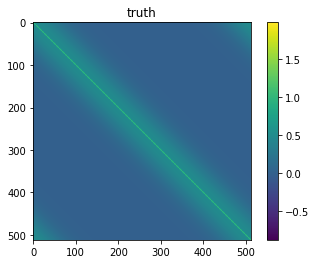

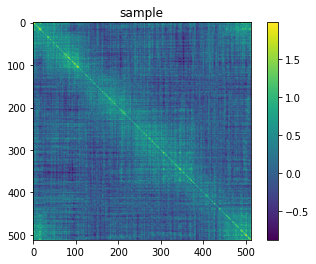

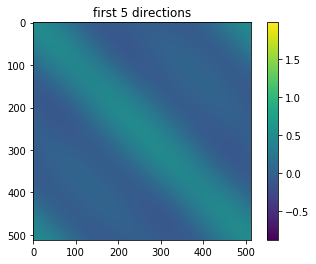

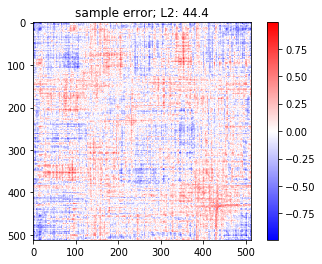

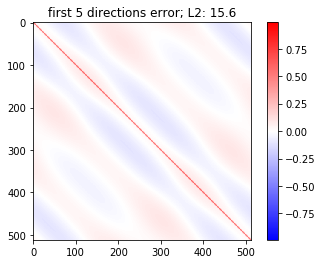

In [747]:
sig_num = 5
test_trans_matrices(P=P,
                    P_sample=P_sample,
                    P_sqrt=P_sqrt,
                    P_inv_sqrt=P_inv_sqrt,
                    VT=VT[:sig_num],
                    title=f'first {sig_num} directions')

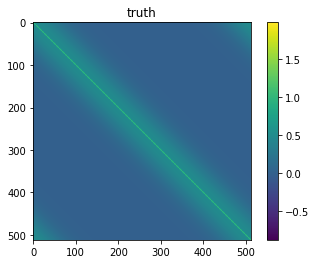

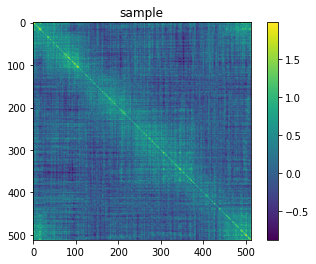

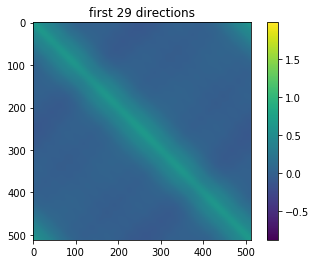

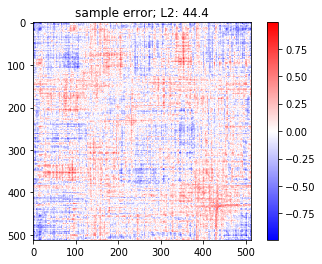

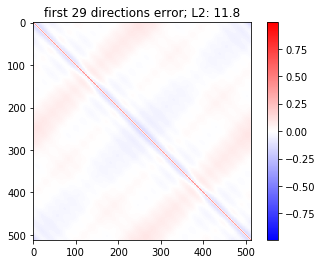

In [750]:
sig_num = 29
P_sample_loc = test_trans_matrices(P=P,
                    P_sample=P_sample,
                    P_sqrt=P_sqrt,
                    P_inv_sqrt=P_inv_sqrt,
                    VT=VT[:sig_num],
                    title=f'first {sig_num} directions')

In [751]:
proj = (np.eye(dimension) - VT[:sig_num].T @ VT[:sig_num])

In [754]:
X_proj = proj @ X

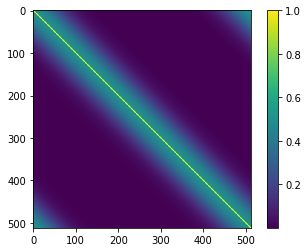

In [756]:
imshow(P)

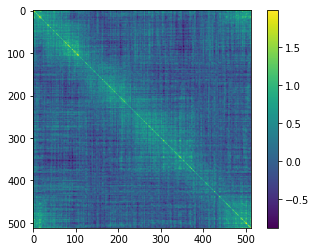

In [757]:
imshow(P_sample)

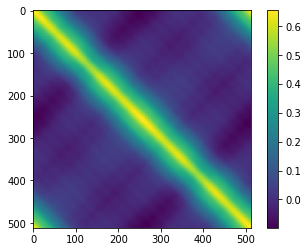

In [758]:
imshow(P_sample_loc)

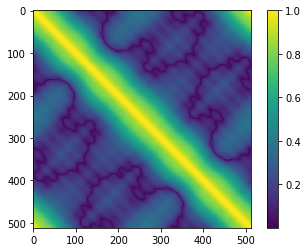

In [825]:
n = 0.5
P_n = (np.abs(P_sample_loc)**n)
loc = np.diag(np.diag(1/np.sqrt(P_n))) @ P_n @ np.diag(np.diag(1/np.sqrt(P_n)))
imshow(loc)

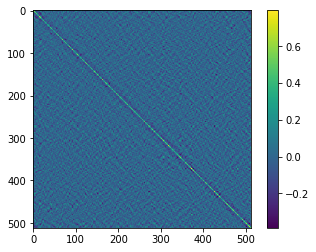

In [826]:
imshow(proj @ P_sample @ proj)

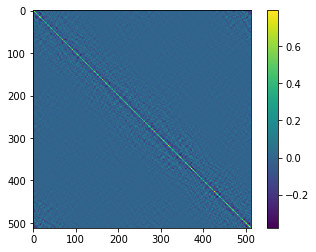

In [827]:
localized_orthogonal = loc * (proj @ P_sample @ proj)
imshow(localized_orthogonal)

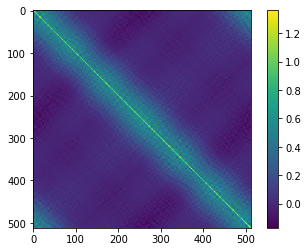

In [828]:
imshow(P_sample_loc + localized_orthogonal)

0.5


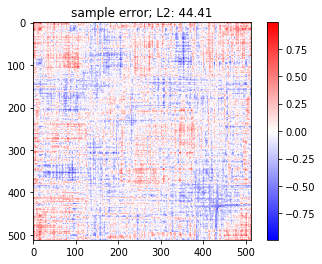

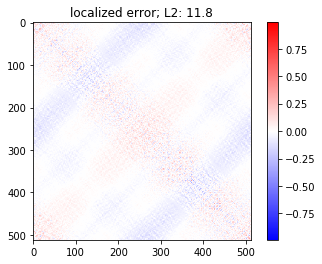

In [829]:
print(n)
error_sample = (P_sample - P)
error_localized = (P_sample_loc + localized_orthogonal) - P
L2_sample = np.round(np.linalg.norm(error_sample, ord=2), decimals=2)
L2_localized = np.round(np.linalg.norm(error_localized, ord=2), decimals=2)
vmax = np.max([np.abs(error_sample).max(), np.abs(error).max()])
imshow(error_sample, vmax=vmax, vmin=-vmax, cmap='bwr',
       title=f'sample error; L2: {L2_sample}')
imshow(error_localized, vmax=vmax, vmin=-vmax, cmap='bwr',
       title=f'localized error; L2: {L2_localized}')

In [1065]:
ens_size = 500
X_large = assimilate.generate_ensemble(ens_size=ens_size,
                                       mu=np.zeros(dimension),
                                       eig_val=eig_val,
                                       eig_vec=eig_vec
                                       )
P_sample_large = np.cov(X_large)

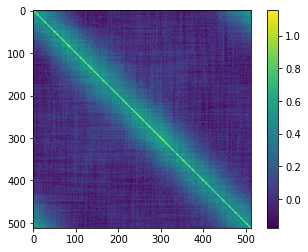

In [1066]:
imshow(P_sample_large)

In [1067]:
subnum = 8
X_subgrid = X_large.reshape(dimension // subnum, subnum, ens_size)
X_subgrid = X_subgrid.mean(axis=1)
P_sample_subgrid = np.cov(X_subgrid)

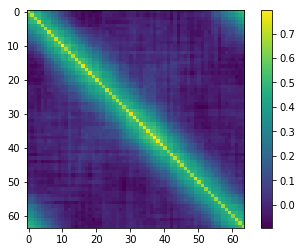

In [1068]:
imshow(P_sample_subgrid)

In [1069]:
H_subgrid = np.eye(P_sample_subgrid.shape[0])
R_subgrid = R_sig * np.eye(P_sample_subgrid.shape[0])
trans_mats = assimilate.transformation_matrices(
    H_subgrid, P=P_sample_subgrid,
    R=R_subgrid, return_Ts=True)

for key, val in trans_mats.items():
    key = key + '_subgrid'
    print(key)
    exec(key + '=val')

P_sqrt_subgrid
P_inv_sqrt_subgrid
R_sqrt_subgrid
R_inv_sqrt_subgrid
U_subgrid
S_subgrid
VT_subgrid
H_subgrid
Tx_subgrid
Tx_inv_subgrid
Ty_subgrid
Ty_inv_subgrid


In [1070]:
x_interp = np.arange(dimension)
# x_data = np.concatenate(
#     [x_interp[::subnum], [x_interp[-1] + 1]]) + 3.5
x_data = x_interp.reshape(int(dimension/subnum), subnum).mean(axis=1)
x_data = np.concatenate([[x_data[0] - subnum],
                         x_data,
                         [x_data[-1] + subnum]])
# x_data = np.concatenate(
#     [x_interp[::subnum], [x_interp[-1] + 1]]) + 3.5

In [1071]:
VT_data = np.concatenate([VT_subgrid[:, -1][:, None],
                          VT_subgrid,
                          VT_subgrid[:, 0][:, None]],
                         axis=1)

In [1072]:
interp_kind = 'cubic'
VT_fun = interpolate.interp1d(x_data, VT_data, kind=interp_kind, axis=1)

In [1073]:
VT_subgrid_interp = VT_fun(x_interp)/np.sqrt(subnum)

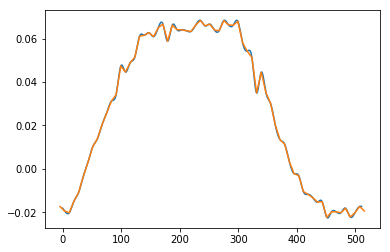

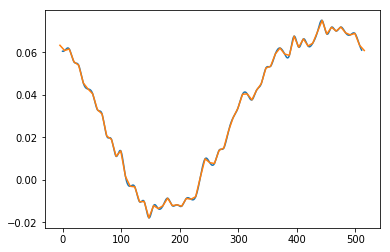

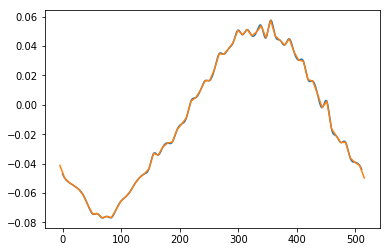

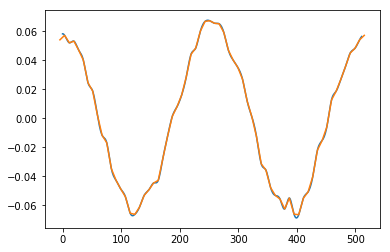

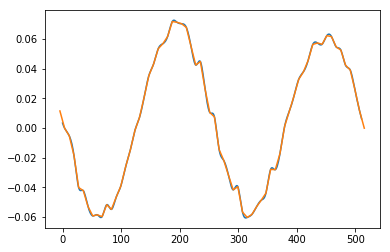

In [1074]:
for ii in range(5):
    plt.figure()
    plt.plot(VT_subgrid_interp[ii])
    plt.plot(x_data, VT_data[ii]/np.sqrt(subnum))

In [1075]:
U_data = np.concatenate([U_subgrid[-1, :][None, :],
                         U_subgrid,
                         U_subgrid[0, :][None, :]],
                        axis=0)

In [1076]:
U_fun = interpolate.interp1d(x_data, U_data, kind=interp_kind, axis=0)

In [1058]:
subnum

8

In [1077]:
U_subgrid_interp = U_fun(x_interp)/np.sqrt(subnum)

In [1078]:
%matplotlib inline

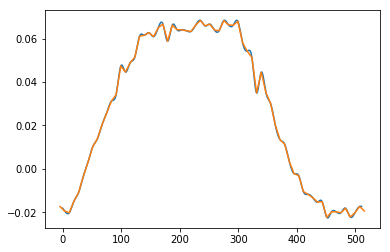

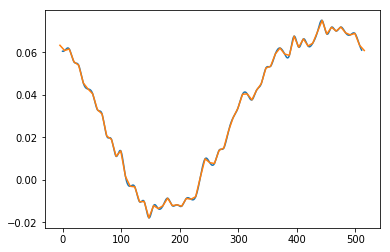

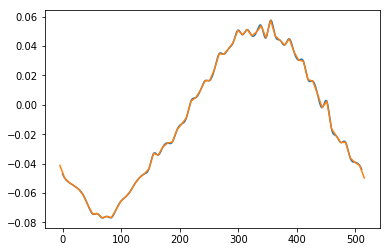

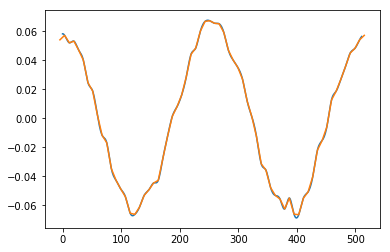

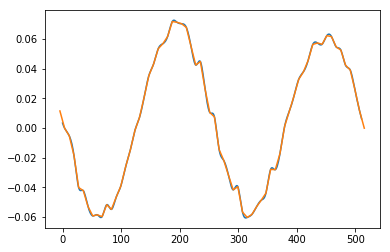

In [1079]:
for ii in range(5):
    plt.figure()
    plt.plot(U_subgrid_interp[:, ii])
    plt.plot(x_data, U_data[:, ii]/np.sqrt(subnum))

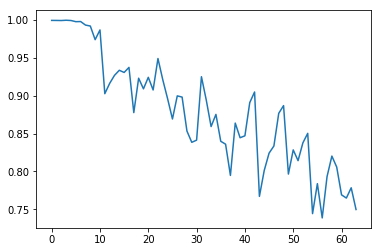

In [1080]:
plt.plot(np.diag(U_subgrid_interp.T @ U_subgrid_interp))

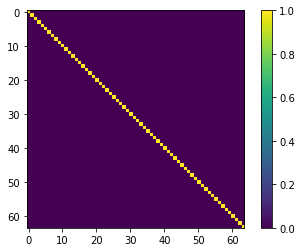

In [1081]:
imshow(U_subgrid.T @ U_subgrid)

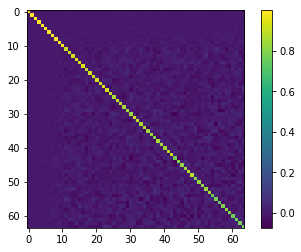

In [1082]:
imshow(U_subgrid_interp.T @ U_subgrid_interp)

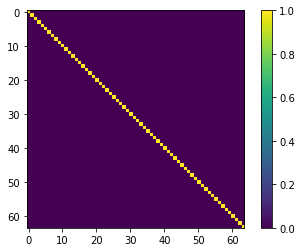

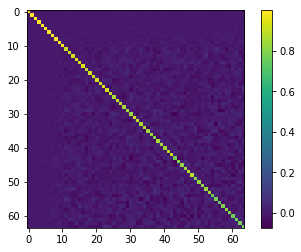

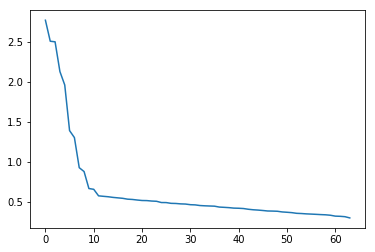

In [1083]:
imshow(VT_subgrid @ VT_subgrid.T)
imshow(VT_subgrid_interp @ VT_subgrid_interp.T)
plt.figure()
plt.plot(np.diag(S_subgrid))

In [1092]:
S_subgrid_interp = S_subgrid * np.sqrt(subnum)

In [1121]:
subgrid_sig_num = 11

In [1122]:
P_sample_interp_sqrt = (
    U_subgrid_interp[:, :subgrid_sig_num]
    @ S_subgrid_interp[:subgrid_sig_num, :subgrid_sig_num]
    @ VT_subgrid_interp[:subgrid_sig_num, :])
P_sample_interp = P_sample_interp_sqrt @ P_sample_interp_sqrt

In [1123]:
%matplotlib notebook

In [1124]:
%matplotlib inline

In [1125]:
P_sample_interp.trace()/dimension

0.5409000838039832

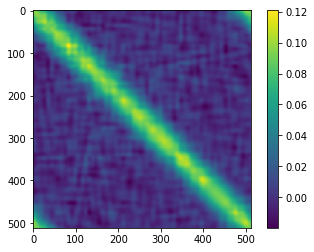

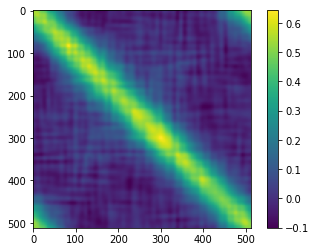

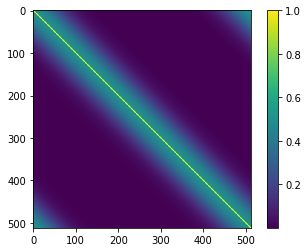

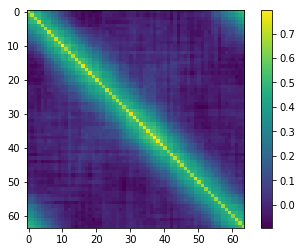

In [1128]:
imshow(P_sample_interp_sqrt)
imshow(P_sample_interp_sqrt @ P_sample_interp_sqrt)
imshow(P)
imshow(P_sample_subgrid)

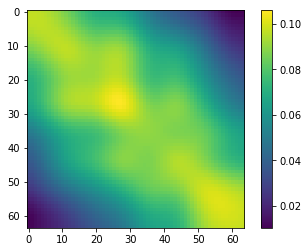

In [1129]:
imshow(P_sample_interp_sqrt[:64, :64])

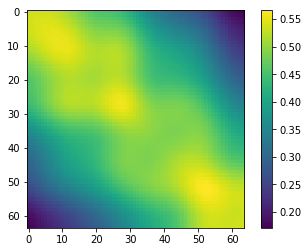

In [1130]:
P_sample_interp = P_sample_interp_sqrt @ P_sample_interp_sqrt
imshow(P_sample_interp[:64, :64])

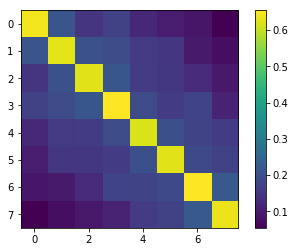

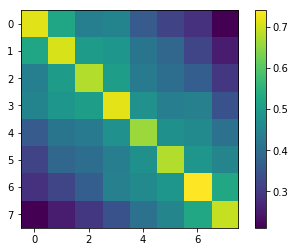

In [1131]:
this = U_subgrid @ S_subgrid @ VT_subgrid
that = this @ this
imshow(this[:8, :8])
imshow(that[:8, :8])

In [1132]:
X_proj = proj @ X

In [1133]:
P_proj = np.cov(X_proj)

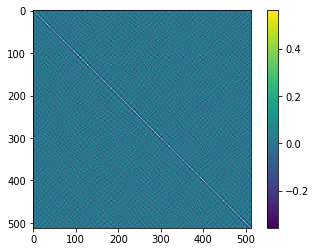

In [1134]:
imshow(P_proj)

In [1142]:
ens_size = 30
X = assimilate.generate_ensemble(ens_size=ens_size,
                                       mu=np.zeros(dimension),
                                       eig_val=eig_val,
                                       eig_vec=eig_vec
                                       )
P_sample = np.cov(X)

In [1143]:
# P_sample_til = VT_subgrid_interp @ P_inv_sqrt @ P_sample @ P_inv_sqrt @ VT_subgrid_interp.T
P_sample_til = VT_subgrid_interp @ P_sample @ VT_subgrid_interp.T

# P_sample_til = P_inv_sqrt @ P_sample @ P_inv_sqrt

In [1145]:
proj = (np.eye(dimension) - VT_subgrid_interp[:subgrid_sig_num].T @ VT_subgrid_interp[:subgrid_sig_num])

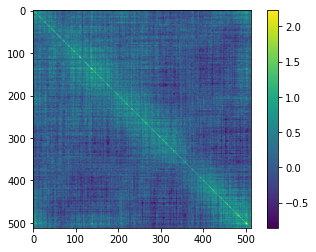

In [1147]:
imshow(P_sample)

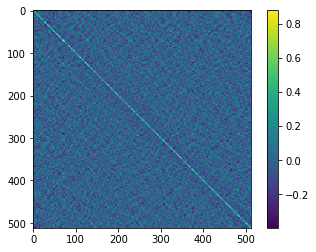

In [1163]:
P_orth = proj @ P_sample @ proj
imshow(P_orth)

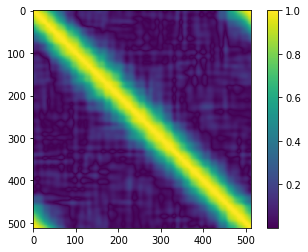

In [1169]:
n = 1
P_n = (np.abs(P_sample_interp)**n)
loc = np.diag(np.diag(1/np.sqrt(P_n))) @ P_n @ np.diag(np.diag(1/np.sqrt(P_n)))
imshow(loc)

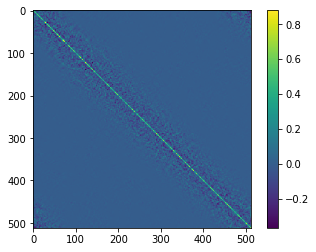

In [1170]:
imshow(loc * P_orth)

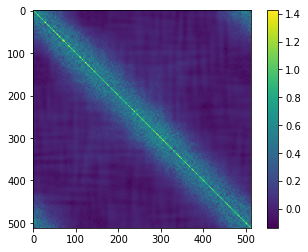

In [1171]:
P_sample_loc = P_sample_interp + loc * P_orth
imshow(P_sample_loc)

1


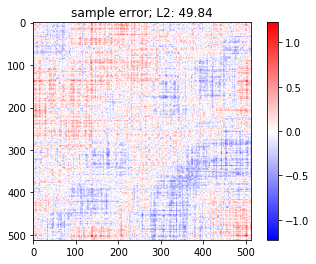

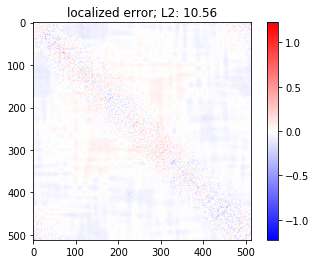

In [1173]:
print(n)
error_sample = (P_sample - P)
error_localized = (P_sample_loc) - P
L2_sample = np.round(np.linalg.norm(error_sample, ord=2), decimals=2)
L2_localized = np.round(np.linalg.norm(error_localized, ord=2), decimals=2)
vmax = np.max([np.abs(error_sample).max(), np.abs(error).max()])
imshow(error_sample, vmax=vmax, vmin=-vmax, cmap='bwr',
       title=f'sample error; L2: {L2_sample}')
imshow(error_localized, vmax=vmax, vmin=-vmax, cmap='bwr',
       title=f'localized error; L2: {L2_localized}')

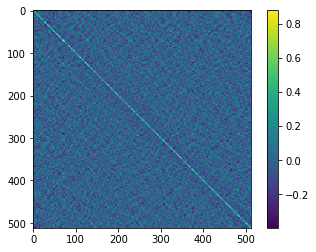

In [1152]:
imshow(proj @ P_sample @ proj)

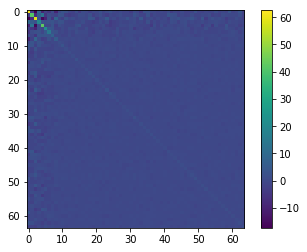

In [1153]:
subgrid_dim = P_sample_subgrid.shape[0]
imshow(P_sample_til)

In [1154]:
rho = np.arange(subgrid_dim)[None, :]
rho = np.abs(rho - rho.T)
rho0 = .5
loc = covariance.correlation_sqd_exp(rho=rho, rho0=rho0)

In [1155]:
P_sample_til_loc = P_sample_til * loc

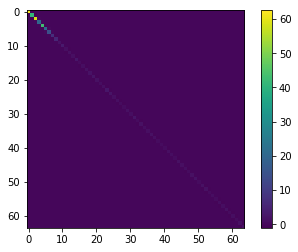

In [1156]:
imshow(P_sample_til_loc)

In [1157]:
# P_sample_loc = P_sqrt @ VT_subgrid_interp.T @ P_sample_til_loc @ VT_subgrid_interp @ P_sqrt
P_sample_loc = VT_subgrid_interp.T @ P_sample_til_loc @ VT_subgrid_interp

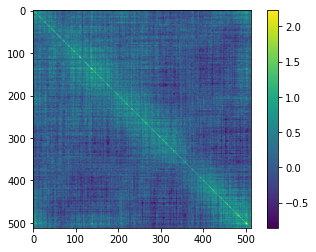

In [1158]:
imshow(P_sample)

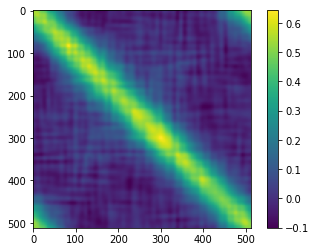

In [1159]:
imshow(P_sample_interp)

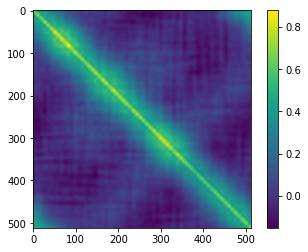

In [1160]:
imshow(P_sample_loc)

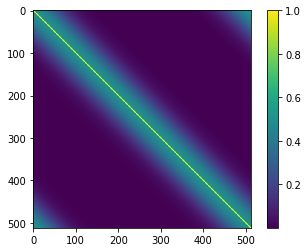

In [1161]:
imshow(P)

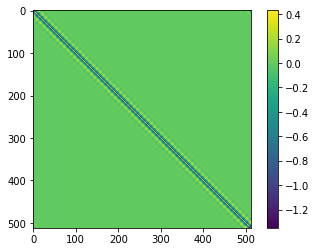

In [972]:
imshow(proj)

In [180]:
S_subgrid.shape

(64, 64)

In [181]:
VT_subgrid_interp.shape

(64, 512)

In [182]:
U_subgrid_interp.shape

(512, 64)

In [183]:
P_sample_interp.shape

(64, 64)

In [364]:
X_til = VT @ P_inv_sqrt @ X
P_sample_til = np.cov(X_til)

rho_smooth = 100
X_smooth = ndimage.gaussian_filter1d(X, sigma=rho_smooth, mode='wrap', axis=0)
X_til_smooth = VT @ P_inv_sqrt @ X_smooth
P_sample_til_smooth = np.cov(X_til_smooth)

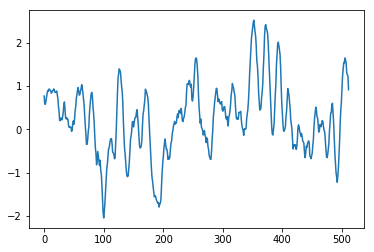

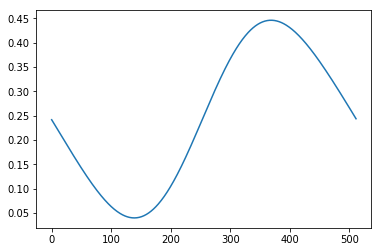

In [365]:
plt.figure()
plt.plot(X[:, 0])

plt.figure()
plt.plot(X_smooth[:, 0])

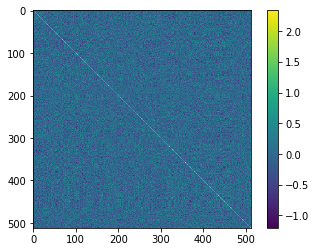

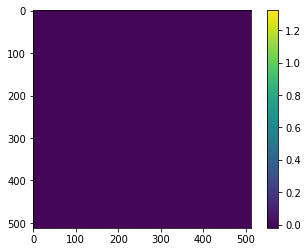

In [366]:
imshow(P_sample_til)
imshow(P_sample_til_smooth)

In [367]:
rho = np.arange(dimension)[None, :]
rho = np.abs(rho - rho.T)

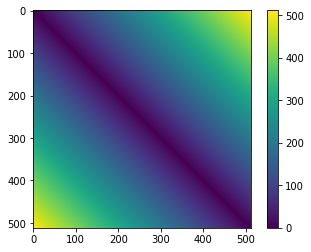

In [368]:
imshow(rho)

In [369]:
rho0 = 5
loc = covariance.correlation_sqd_exp(rho=rho, rho0=rho0)

In [370]:
P_sample_til_loc_smooth = loc * P_sample_til_smooth
# P_sample_til_loc_smooth = np.diag(np.diag(P_sample_til_loc_smooth))
P_sample_til_loc = loc * P_sample_til
# P_sample_til_loc = np.diag(np.diag(P_sample_til))

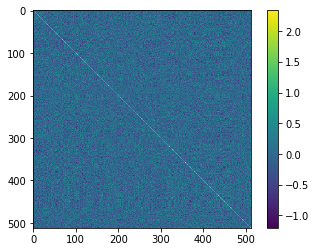

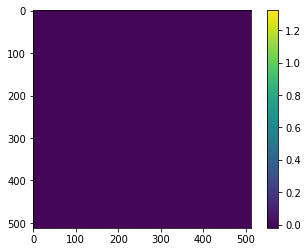

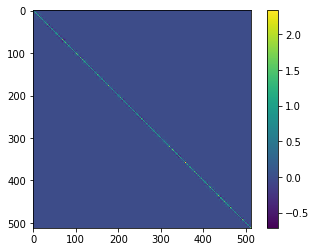

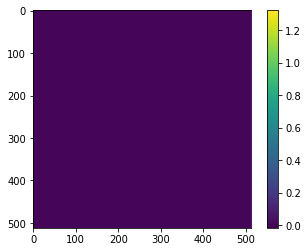

In [371]:
imshow(P_sample_til)
imshow(P_sample_til_smooth)
# imshow(loc)
imshow(P_sample_til_loc)
imshow(P_sample_til_loc_smooth)

In [372]:
# P_sample_til_loc_sqrt = np.real(covariance.matrix_sqrt(C=P_sample_til_loc))
# P_sample_til_loc_sqrt_smooth = np.real(covariance.matrix_sqrt(C=P_sample_til_loc_smooth))

In [373]:
# X_til_loc = assimilate.generate_ensemble(ens_size=ens_size*1000,
#                                          mu=np.zeros(dimension),
#                                          P_sqrt=P_sample_til_loc_sqrt)

In [374]:
# X_loc = P_sqrt @ VT.T @ X_til_loc

In [375]:
# imshow(P_sample_til_loc)

In [376]:
# P_sample_loc = np.cov(X_loc)

In [377]:
P_sample_loc = P_sqrt @ VT.T @ P_sample_til_loc @ VT @ P_sqrt
P_sample_loc_smooth = P_sqrt @ VT.T @ P_sample_til_loc_smooth @ VT @ P_sqrt

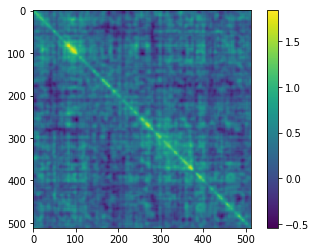

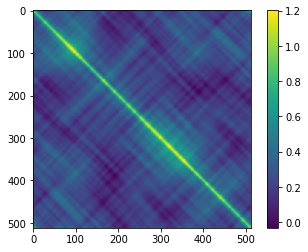

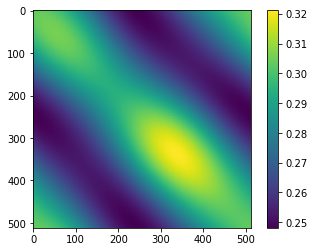

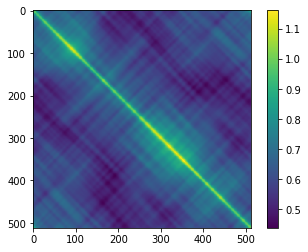

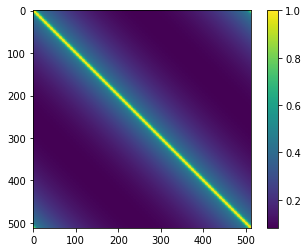

In [382]:
imshow(P_sample)
imshow(P_sample_loc)
imshow(P_sample_loc_smooth)
imshow(0.5*(P_sample_loc + 3.5*P_sample_loc_smooth))
imshow(P)

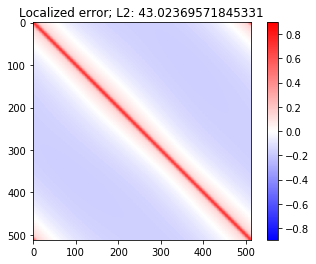

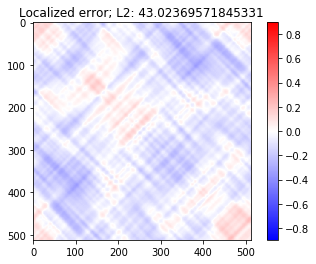

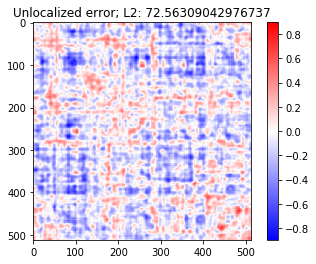

In [380]:
err_loc_smooth = P - P_sample_loc_smooth
L2_loc_smooth = np.linalg.norm(err_loc_smooth, ord=2)
err_loc = P - P_sample_loc
L2_loc = np.linalg.norm(err_loc, ord=2)
err = P - P_sample
L2 = np.linalg.norm(err, ord=2)
vmax = np.max(
    [np.abs(err_loc_smooth).max(),
     np.abs(err_loc).max(),
     np.abs(err).max()])
imshow(err_loc_smooth,
       vmax=vmax, vmin=-vmax, cmap='bwr',
       title=f'Localized error; L2: {L2_loc_smooth}')
imshow(err_loc,
       vmax=vmax, vmin=-vmax, cmap='bwr',
       title=f'Localized error; L2: {L2_loc}')
imshow(err,
       vmax=vmax, vmin=-vmax, cmap='bwr',
       title=f'Unlocalized error; L2: {L2}')